# From  [Managing Smile Risk](http://web.math.ku.dk/~rolf/SABR.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from ito_diffusions import SABR

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from volmodels import *
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
T = 1.0
SCHEME_STEPS = int(1e4)
ONE_BP = 1e-4
ONE_PCT = 1e-2
N_STRIKES = 500

## Diffusion equation

* $dX_t = \sigma_tC(X_t)dW_t$

* $d\sigma_t = \eta \sigma_tdB_t$

* $d<W,B>_t = \rho dt$

* $C(x) = x^\beta$

## Sample paths

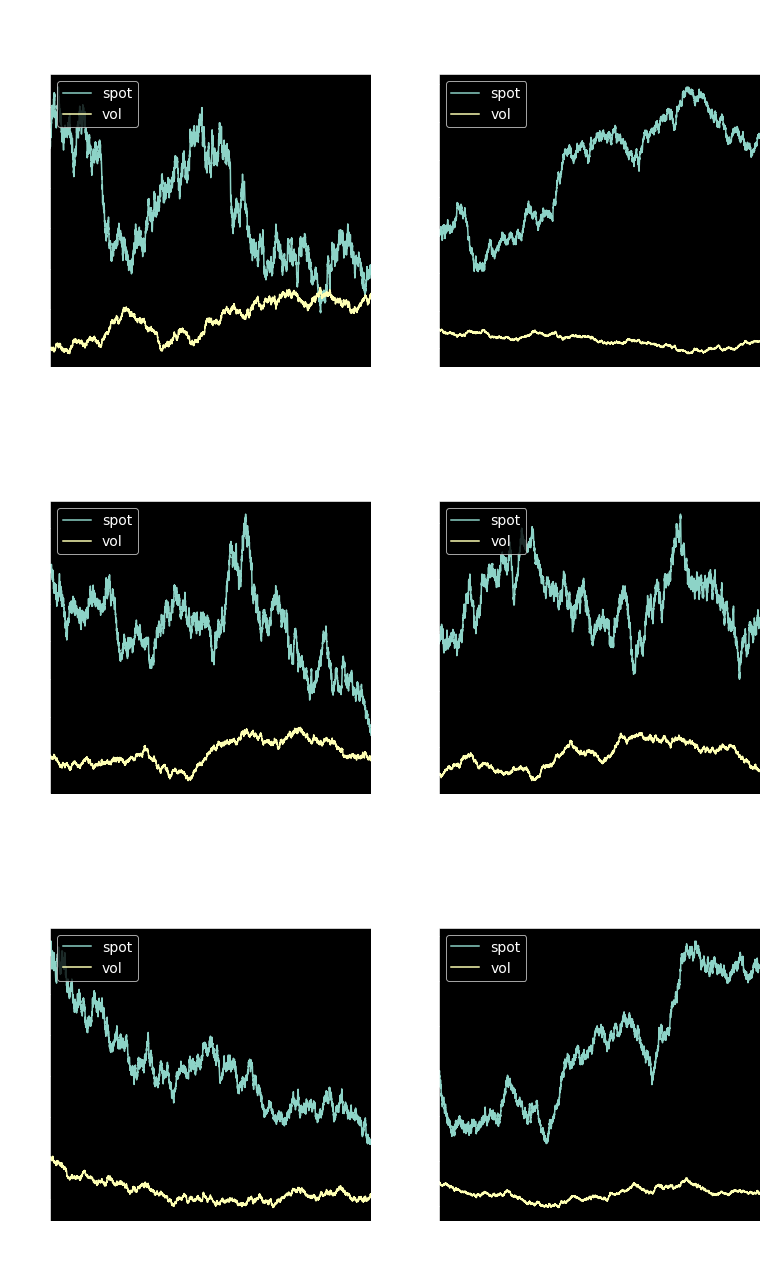

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=2)

x0 = [1, 0.5]

params = [
    [1.0, 0.2, -0.5],
    [1.0, 0.2, 0.0],
    [1.0, 0.2, 0.5],
    [0.0, 0.2, -0.5],
    [0.0, 0.2, 0.0],
    [0.0, 0.2, 0.5],
]

X = SABR(x0=x0, T=T, scheme_steps=SCHEME_STEPS, keys=['spot', 'vol'])

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        beta = params[i+3*j][0]
        vov = params[i+3*j][1]
        rho = params[i+3*j][2]

        X.beta = beta
        X.vov = vov
        X.rho = rho
        
        df = X.simulate()
        df.plot(kind='line', ax=ax)

        ax.set_xlabel('time\n')
        ax.set_ylabel('spot')
        ax.legend(loc='upper left')
        ax.set_title(r'$\beta$={:.2}'.format(beta)+'\n'\
                     r'vov={:.0%}'.format(vov)+'\n'\
                     r'$\rho$={:.0%}'.format(rho),\
                    )

plt.tight_layout()
plt.show()

## Numerical experiments

In [5]:
f = 2*ONE_PCT
beta = 0.2
vov = 40*ONE_PCT
rho = -40*ONE_PCT
logmoneyness_lo = -1.5
logmoneyness_hi = 0.5
sigma_0 = 27*ONE_BP

In [6]:
Model_LN = SABR_Hagan_LN(beta=beta, 
                         vov=vov, 
                         rho=rho, 
                         f=f,
                         marking_mode='sigma_0', 
                         sigma_0=sigma_0,
                         n_strikes=N_STRIKES,
                         logmoneyness_lo=logmoneyness_lo,
                         logmoneyness_hi=logmoneyness_hi
                        )
Model_N = SABR_Hagan_N(beta=beta,
                       vov=vov,
                       rho=rho,
                       f=f,
                       marking_mode='sigma_0', 
                       sigma_0=sigma_0,
                       n_strikes=N_STRIKES,
                       logmoneyness_lo=logmoneyness_lo,
                       logmoneyness_hi=logmoneyness_hi
                      )

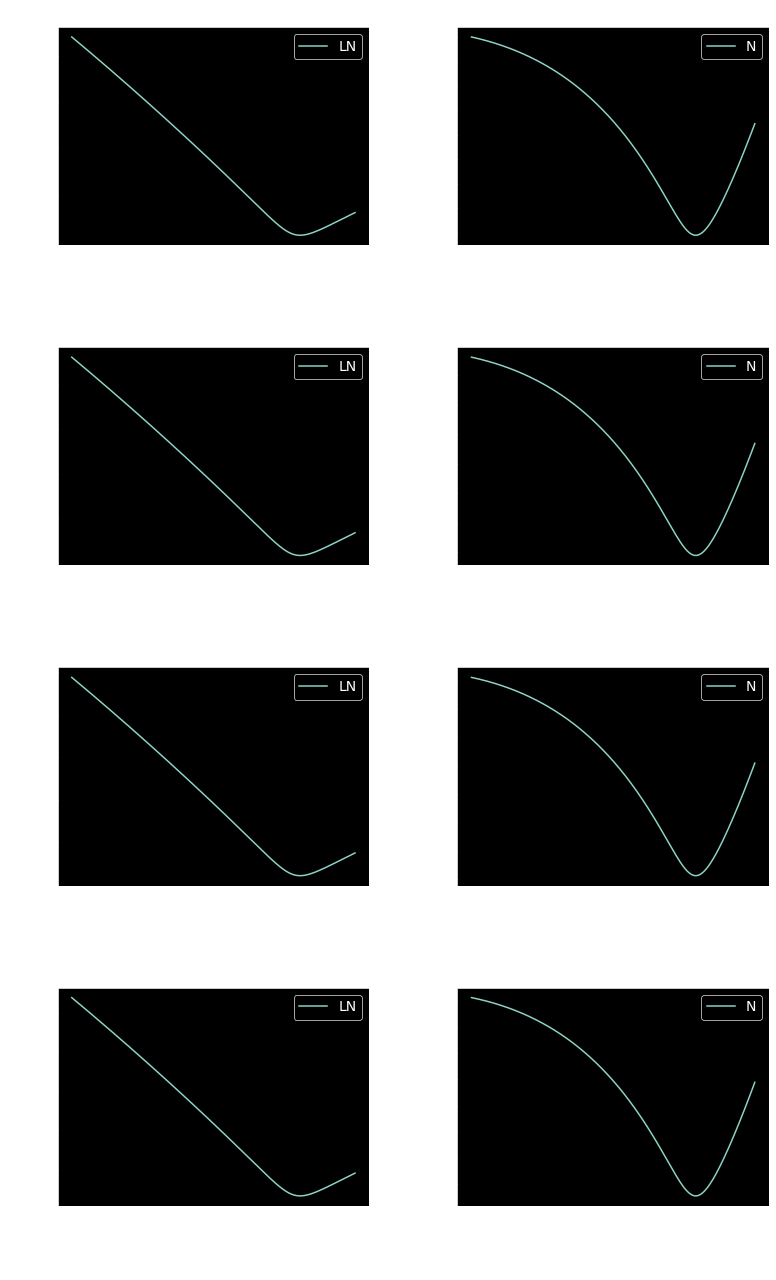

In [7]:
xlabel = 'logmoneyness\n\n'
ylabel = 'implied vol'
labels = ['LN', 'N']

T_expiries = [1.0, 5.0, 10.0, 20.0]

fig, axes = plt.subplots(nrows=4, ncols=2)

for i, ax_row in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_LN.T_expiry = T_expiry
    Model_N.T_expiry = T_expiry
    x_grid = Model_LN.logmoneyness_grid

    models = [Model_LN, Model_N]
    for j, ax in enumerate(ax_row):
        model = models[j]
        label = labels[j]
        smile = list(model.smile.values())
        
        ax.plot(x_grid, smile, label=label)

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right')
        ax.set_title('expiry={}y'.format(T_expiry))

plt.tight_layout()
plt.show()

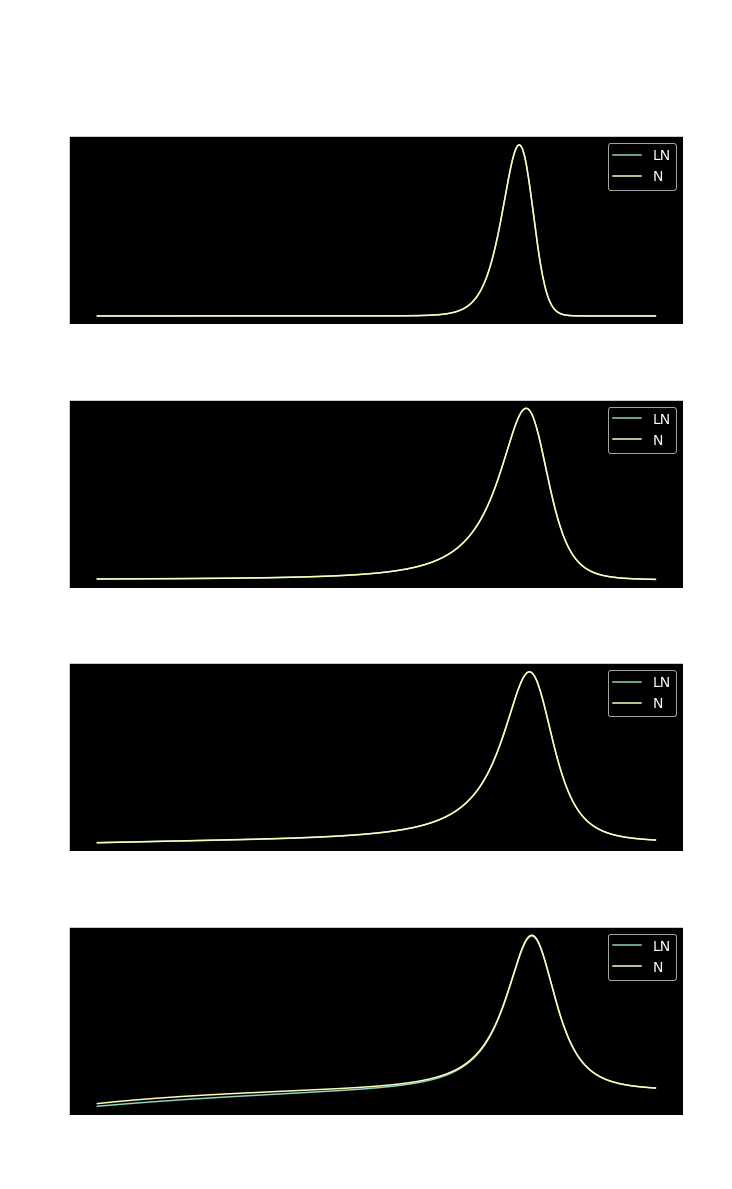

In [8]:
xlabel = 'logmoneyness\n\n'
ylabel = 'pdf'

T_expiries = [1.0, 5.0, 10.0, 20.0]

fig, axes = plt.subplots(nrows=4, ncols=1)

plt.suptitle(r'$f$={:.2%}'.format(Model_LN.f)+', '+\
             r'$\beta$={:.2}'.format(Model_LN.beta)+', '+\
             r'vov={:.0%}'.format(Model_LN.vov)+', '+\
             r'$\rho$={:.0%}'.format(Model_LN.rho)+', '+\
             r'ATM(LN)={:.2%}, ATM(N)={:.2f}bps'.format(Model_LN.ATM, Model_N.ATM/ONE_BP)+', '+\
             r'$\sigma_0$={:.2%}'.format(Model_LN.sigma_0)
            )

for i, ax in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_LN.T_expiry = T_expiry
    Model_N.T_expiry = T_expiry
    
    x_grid = Model_LN.logmoneyness_grid
    
    pdf_LN = list(Model_LN.pdf_curve.values())
    pdf_N = list(Model_N.pdf_curve.values())

    ax.plot(x_grid, pdf_LN, label='LN')
    ax.plot(x_grid, pdf_N, label='N')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.set_title(r'expiry={}y'.format(T_expiry))

plt.subplots_adjust(hspace=0.4)
plt.show()

In [9]:
# T_expiry = 20.0
# Model_LN = SABR_Hagan_LN(beta=beta, 
#                          vov=vov, 
#                          rho=rho,
#                          f=f,
#                          T_expiry=T_expiry,
#                          marking_mode='sigma_0',
#                          sigma_0=sigma_0,
#                          n_strikes=N_STRIKES,
#                          logmoneyness_lo=logmoneyness_lo,
#                          logmoneyness_hi=logmoneyness_hi
#                         )
# Model_N = SABR_Hagan_N(beta=beta,
#                        vov=vov,
#                        rho=rho,
#                        f=f,
#                        T_expiry=T_expiry,
#                        marking_mode='sigma_0',
#                        sigma_0=sigma_0,
#                        n_strikes=N_STRIKES,
#                        logmoneyness_lo=logmoneyness_lo,
#                        logmoneyness_hi=logmoneyness_hi
#                       )

# Model_MC = SABR_MC(beta=beta, 
#                    vov=vov,
#                    rho=rho,
#                    f=f,
#                    vol_type='LN',
#                    marking_mode='sigma_0',
#                    sigma_0=sigma_0,
#                    T_expiry=T_expiry,
#                    n_strikes=100,
#                    logmoneyness_lo=logmoneyness_lo,
#                    logmoneyness_hi=logmoneyness_hi,
#                    n_sim = 20000, 
#                    scheme_steps=500
#                   )

## Probability density implied by normal and lognormal Hagan formula vs Monte Carlo estimation

Hagan vol expansion breaks on the left wing for long expiries and implies negative density.
Around ATM and on the right wing, both normal and lognormal expansions induce densities which are consistent with Monte Carlo.

In [10]:
# xlabel = 'logmoneyness\n\n'
# ylabel = 'pdf'

# fig, axes = plt.subplots(nrows=3, ncols=1)

# Model_LN.n_strikes = Model_MC.n_strikes
# Model_N.n_strikes = Model_MC.n_strikes

# moneyness_los = [-1.5, -1.0, -0.5]

# plt.suptitle(r'$f$={:.2%}'.format(Model_LN.f)+', '+\
#              r'$\beta$={:.2}'.format(Model_LN.beta)+', '+\
#              r'vov={:.0%}'.format(Model_LN.vov)+', '+\
#              r'$\rho$={:.0%}'.format(Model_LN.rho)+', '+\
#              r'ATM(LN)={:.2%}, ATM(N)={:.2f}bps'.format(Model_LN.ATM, Model_N.ATM/ONE_BP)+', '+\
#              r'$\sigma_0$={:.2%}'.format(Model_LN.sigma_0)+', '+\
#              r'expiry={}y'.format(T_expiry)
#             )

# for i, ax in enumerate(axes):
#     Model_LN.logmoneyness_lo = logmoneyness_los[i]
#     Model_N.logmoneyness_lo = logmoneyness_los[i]
#     Model_MC.logmoneyness_lo = logmoneyness_los[i]

#     x_grid = Model_MC.logmoneyness_grid

#     pdf_LN = Model_LN.pdf_curve.values()
#     pdf_N = Model_N.pdf_curve.values()
#     pdf_MC = Model_MC.pdf_curve.values()

#     ax.plot(x_grid, pdf_LN, label='LN')
#     ax.plot(x_grid, pdf_N, label='N')
#     ax.plot(x_grid, pdf_MC, label='MC')

#     ax.set_xlabel(xlabel)
#     ax.set_ylabel(ylabel)
#     ax.legend(loc='upper right')

# plt.subplots_adjust(hspace=0.4)
# plt.show()

In [11]:
# Model_MC.smile_plot(log_moneyness=True)
# Model_MC.pdf_plot(log_moneyness=True)

## Backbone i.e ATM vol move implied by forward move

The smile dynamics is mostly controlled by $\beta$ via the approximate relation :
$\beta = 1+\frac{\Delta \log ATM_{Black}}{\Delta \log F}$

In lognormal space :
* $\beta=1$ : flat backbone, the ATM remains the same when the forward moves (sticky by delta),
* $\beta=0$ : decreasing backbone, the ATM is higher for lower forward.

The opposite rules apply in normal space :
* $\beta=1$ : increasing backbone, the ATM is lower for lower forward,
* $\beta=0$ : flat backbone.

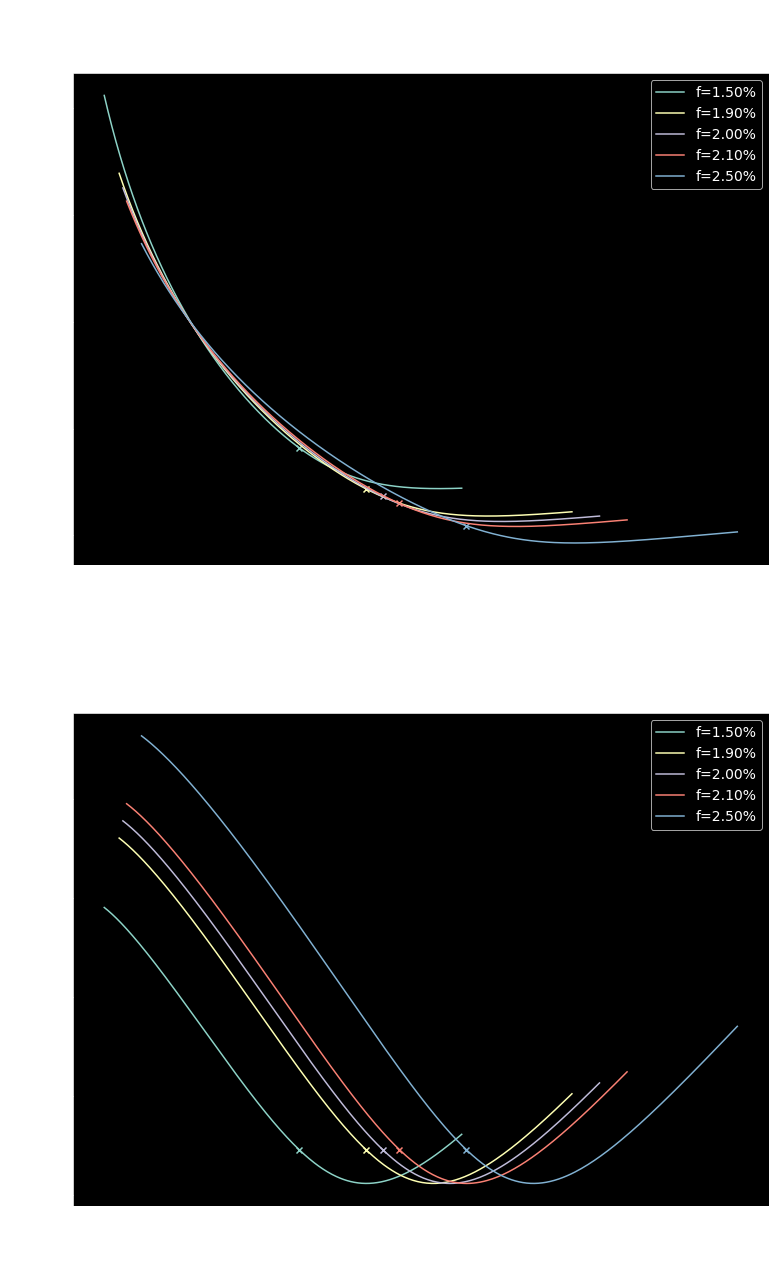

In [12]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 2*ONE_PCT
sigma_0 = 27*ONE_BP

f_shocks = [
    -50*ONE_BP, 
    -10*ONE_BP, 
    0, 
    10*ONE_BP, 
    50*ONE_BP
]

logmoneyness_lo = -1.5
logmoneyness_hi = 0.5

Model_LN = SABR_Hagan_LN(beta=0.0,
                         vov=vov,
                         rho=rho,
                         f=f,
                         marking_mode='sigma_0',
                         sigma_0=sigma_0,
                         n_strikes=N_STRIKES,
                         logmoneyness_lo=logmoneyness_lo,
                         logmoneyness_hi=logmoneyness_hi
                        )
Model_N = SABR_Hagan_N(beta=0.0, 
                       vov=vov, 
                       rho=rho,
                       f=f,
                       marking_mode='sigma_0',
                       sigma_0=sigma_0,
                       n_strikes=N_STRIKES,
                       logmoneyness_lo=logmoneyness_lo,
                       logmoneyness_hi=logmoneyness_hi
                      )

models = [Model_LN, Model_N]

fig, axes = plt.subplots(nrows=2, ncols=1)
    
for i, ax in enumerate(axes):
    model = models[i]
    for f_shock in f_shocks:
        model.f = f+f_shock
        smile = list(model.smile.values())
        label = 'f={:.2%}'.format(f+f_shock)
        ax.plot(model.strike_grid, smile, label=label)
        ax.scatter([model.f], [model.ATM], marker='x')

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right')
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
        ax.set_title('{}\n'.format(model.vol_type)+r'$\beta$={}'.format(Model_LN.beta)+'\n')

plt.tight_layout()
plt.show()

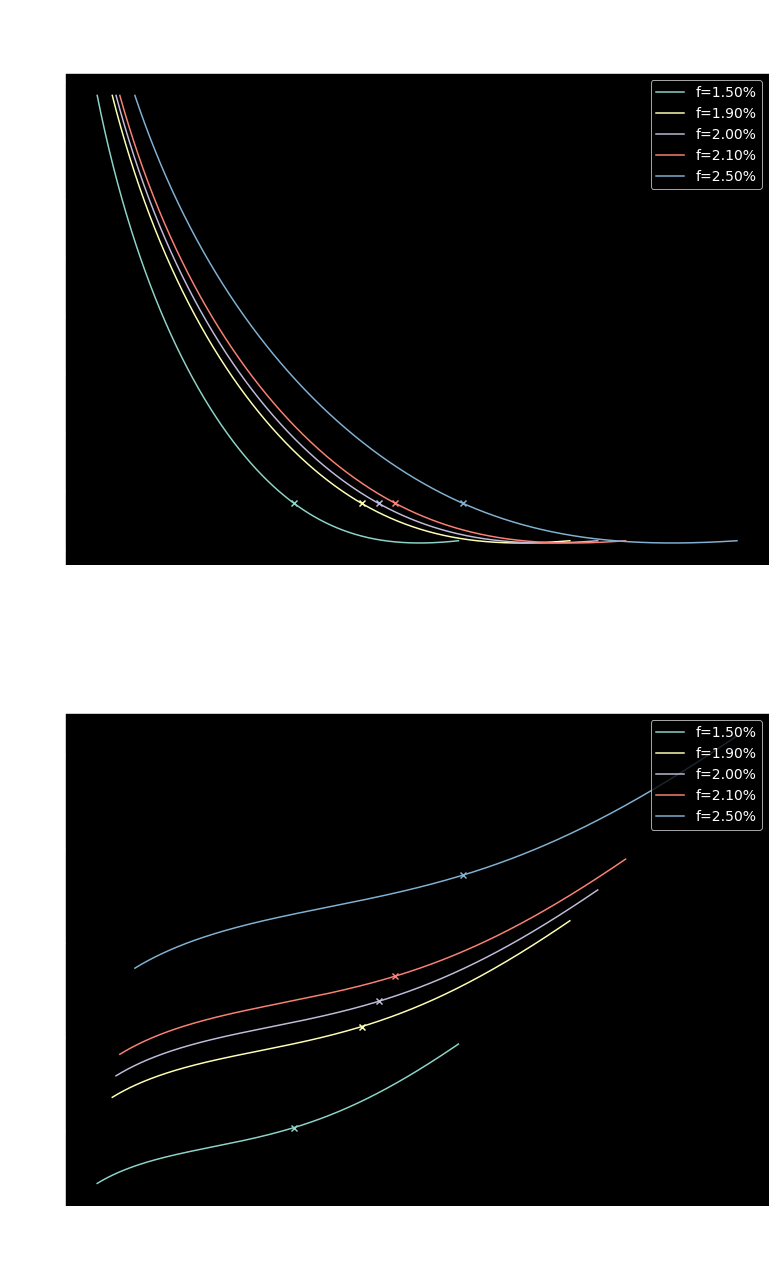

In [13]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 2*ONE_PCT
sigma_0 = 27*ONE_PCT
f_shocks = [
    -50*ONE_BP, 
    -10*ONE_BP, 
    0, 
    10*ONE_BP, 
    50*ONE_BP
]

logmoneyness_lo = -1.5
logmoneyness_hi = 0.5

Model_LN = SABR_Hagan_LN(beta=1.0, 
                         vov=vov, 
                         rho=rho,
                         f=f,
                         marking_mode='sigma_0', 
                         sigma_0=sigma_0,
                         n_strikes=N_STRIKES,
                         logmoneyness_lo=logmoneyness_lo,
                         logmoneyness_hi=logmoneyness_hi
                        )

Model_N = SABR_Hagan_N(beta=1.0,
                       vov=vov,
                       rho=rho,
                       f=f,
                       marking_mode='sigma_0',
                       sigma_0=sigma_0,
                       n_strikes=N_STRIKES,
                       logmoneyness_lo=logmoneyness_lo,
                       logmoneyness_hi=logmoneyness_hi
                      )

models = [Model_LN, Model_N]

fig, axes = plt.subplots(nrows=2, ncols=1)
    
for i, ax in enumerate(axes):
    model = models[i]
    for f_shock in f_shocks:
        model.f = f+f_shock
        smile = list(model.smile.values())
        label = 'f={:.2%}'.format(f+f_shock)
        ax.plot(model.strike_grid, smile, label=label)
        ax.scatter([model.f], [model.ATM], marker='x')

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right')
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
        ax.set_title('{}\n'.format(model.vol_type)+r'$\beta$={}'.format(Model_LN.beta)+'\n')

plt.tight_layout()
plt.show()

## Parameter sensitivities

Vol of vol controls the convexity of the smile, rho the skew (i.e rotation around the ATM).
Both have little to no effect on the ATM itself.

$\sigma_0$ controls the ATM via parallel shifts of the whole smile

$\beta$ also controls the ATM (as it changes the shape of the local vol function) and a little bit the skew. In this sense, it is redundant with the other parameters. However, as seen before, it strongly defines the shape of the backbone.

Typically, $\beta$ is first chosen to match the observed (or assumed) dynamics of the smile. Then the other parameters are calibrated to market data. Note that this calibration can often be decomposed in two steps : 

* Mark the ATM : that can be achieved by tuning $\sigma_0$
* Calibrate correlation and vol of vol to fit the smile.

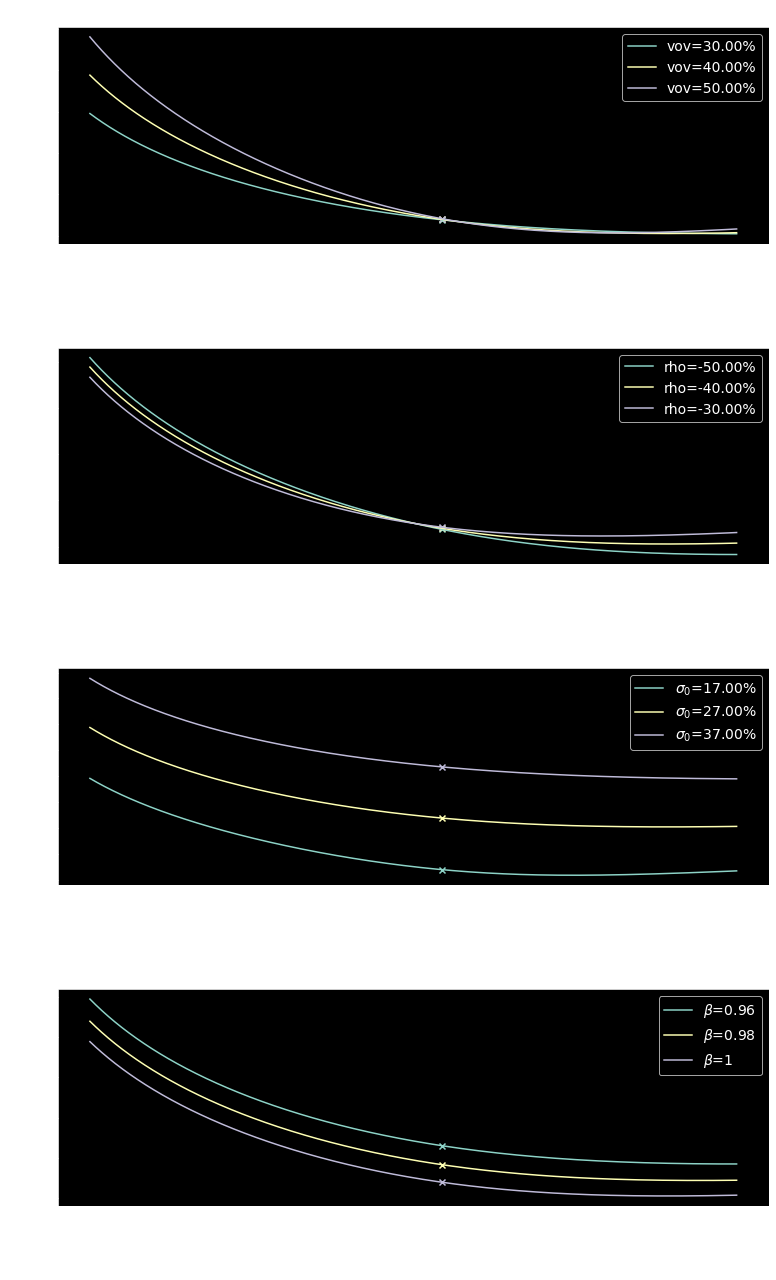

In [14]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 2*ONE_PCT

vov_shocks = [-0.1, 0, 0.1]
rho_shocks = [-0.1, 0, 0.1]
sigma_0_shocks = [-0.1, 0, 0.1]
betas = [0.96, 0.98, 1]

vov = 40*ONE_PCT
rho = -40*ONE_PCT
sigma_0 = 27*ONE_PCT

logmoneyness_lo = -1.5
logmoneyness_hi = 0.5

fig, axes = plt.subplots(nrows=4, ncols=1)

ax = axes[0]  
model = SABR_Hagan_LN(beta=1.0, 
                      vov=vov,
                      rho=rho,
                      f=f,
                      marking_mode='sigma_0', 
                      sigma_0=sigma_0,
                      n_strikes=N_STRIKES,
                      logmoneyness_lo=logmoneyness_lo,
                      logmoneyness_hi=logmoneyness_hi
                     )

for vov_shock in vov_shocks:
    model.vov = vov+vov_shock
    
    smile = list(model.smile.values())
    label = 'vov={:.2%}'.format(vov+vov_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title('Vol of vol shock')

ax = axes[1]
model = SABR_Hagan_LN(beta=1.0, 
                      vov=vov, 
                      rho=rho,
                      f=f,
                      marking_mode='sigma_0',
                      sigma_0=sigma_0,
                      n_strikes=N_STRIKES,
                      logmoneyness_lo=logmoneyness_lo,
                      logmoneyness_hi=logmoneyness_hi
                     )

for rho_shock in rho_shocks:
    model.rho = rho+rho_shock
    
    smile = list(model.smile.values())
    label = 'rho={:.2%}'.format(rho+rho_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title('Correlation shock')
    
ax = axes[2]
model = SABR_Hagan_LN(beta=1.0, 
                      vov=vov,
                      rho=rho,
                      f=f,
                      marking_mode='sigma_0',
                      sigma_0=sigma_0,
                      n_strikes=N_STRIKES,
                      logmoneyness_lo=logmoneyness_lo,
                      logmoneyness_hi=logmoneyness_hi
                     )

for sigma_0_shock in sigma_0_shocks:
    model.sigma_0 = sigma_0+sigma_0_shock

    smile = list(model.smile.values())
    label = r'$\sigma_0$={:.2%}'.format(sigma_0+sigma_0_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title('Initial vol shock')

ax = axes[3]
model = SABR_Hagan_LN(beta=1.0, 
                      vov=vov,
                      rho=rho,
                      f=f,
                      marking_mode='sigma_0', 
                      sigma_0=sigma_0,
                      n_strikes=N_STRIKES,
                      logmoneyness_lo=logmoneyness_lo,
                      logmoneyness_hi=logmoneyness_hi
                     )

for beta in betas:
    model.beta = beta
    smile = list(model.smile.values())
    label = r'$\beta$={}'.format(beta)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title(r'$\beta$ shock')
    
plt.tight_layout()
plt.show()